In [125]:
import os
from os.path import exists, join, basename, splitext

import random
import PIL
import torchvision
import cv2
import numpy as np
import torch
torch.set_grad_enabled(False)

import time
import matplotlib
import matplotlib.pylab as plt

from scipy.stats import multivariate_normal

import tifffile as tf
from sklearn.cluster import KMeans

In [126]:
plt.rcParams["axes.grid"] = False

model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.eval()
# model = model.eval().cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [127]:
IMAGE_URL = 'lena_color_256.tif'

In [128]:
# Open the image file
image = PIL.Image.open(IMAGE_URL)

In [129]:
# Convert the image to a tensor and normalize
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), normalize])
image_tensor = preprocess(image).unsqueeze(0)
# image_tensor = preprocess(image).unsqueeze(0).cuda()

In [130]:
# Run the DeepLabV3 model on the image
t = time.time()
output = model(image_tensor)['out']
print(f'DeepLabV3 executed in {time.time() - t:.3f}s')


DeepLabV3 executed in 2.135s


In [131]:
# Convert the output tensor to numpy array and remove batch dimension
segmentation_output = output.argmax(1).squeeze().cpu().numpy()

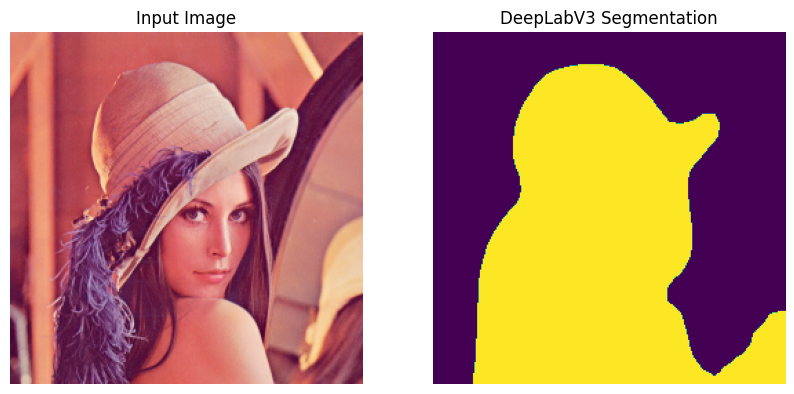

In [132]:
# Display the input image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Input Image')
plt.axis('off')

# Display the segmentation output
plt.subplot(1, 2, 2)
plt.imshow(segmentation_output, cmap='viridis')
plt.title('DeepLabV3 Segmentation')
plt.axis('off')
plt.show()

In [133]:
# EM algorithm
c_image = np.array(image)
height, width, channels = c_image.shape
print(height, width, channels)


256 256 3


In [134]:
# Set the number of Gaussian components
K = 5
# Regularization parameter
epsilon = 1e-6

In [135]:
kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
means = kmeans.cluster_centers_
covs = [np.cov(X[kmeans.labels_ == k].T) for k in range(K)]
weights = np.ones(K) / K

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [136]:
# EM algorithm
max_iter = 100
log_likelihoods = []

In [137]:
for i in range(max_iter):
    # E-step: Calculate the responsibilities
    responsibilities = np.zeros((X.shape[0], K))
    for k in range(K):
        responsibilities[:, k] = weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covs[k] + epsilon*np.eye(channels))
    responsibilities /= np.sum(responsibilities, axis=1, keepdims=True)

    # M-step: Update the parameters
    N = X.shape[0]
    new_weights = np.sum(responsibilities, axis=0) / N
    new_means = np.dot(responsibilities.T, X) / np.sum(responsibilities, axis=0, keepdims=True).T
    new_covs = [np.zeros((channels, channels)) for _ in range(K)]
    for k in range(K):
        diff = X - new_means[k]
        new_covs[k] = np.dot((responsibilities[:, k] * diff.T), diff) / np.sum(responsibilities[:, k])

    # Calculate the log-likelihood
    log_likelihood_vals = np.array([weights[k] * multivariate_normal.pdf(X, mean=means[k], cov=covs[k] + epsilon*np.eye(channels)) for k in range(K)]).T
    log_likelihood = np.sum(np.log(np.sum(log_likelihood_vals, axis=1)))
    log_likelihoods.append(log_likelihood)

    # Check for convergence
    if i > 0 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < 1e-6:
        break

    # Update the parameters
    means = new_means
    covs = new_covs
    weights = new_weights

In [138]:
# Perform segmentation
segmentation = np.argmax(responsibilities, axis=1).reshape(height, width)


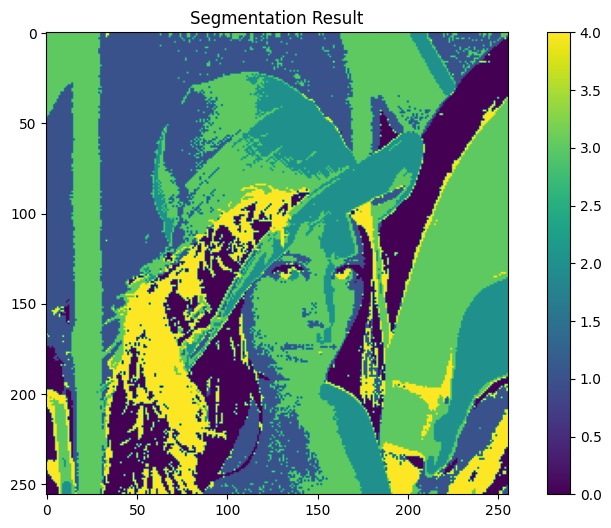

In [139]:
# Visualize the segmentation result
plt.figure(figsize=(10, 6))
plt.imshow(segmentation, cmap='viridis')
plt.title('Segmentation Result')
plt.colorbar()
plt.show()